#Imports and GPU Configuration

In [1]:
# Set some environment variables
import os
gpu_num = 0 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Other imports
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMaterial, PlanarArray, Transmitter, Receiver
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel
from sionna.rt import load_scene, BackscatteringPattern, LambertianPattern, DirectivePattern
# Fix the seed for reproducible results
tf.random.set_seed(42)

We need import the cape town scene. To know how to do it, please refere to the README.md file. Then we define the scene freqeuncy and transmitter for coverage map calculation.    

In [2]:
scene = load_scene("cape_town/cape_town.xml")
f = 3.5e9
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
# Place a transmitter
tx = Transmitter("tx", position=[-92,3,33], look_at=[0,0,0])
scene.add(tx)
target_center1 = np.array([-77,-40,1.5]) # Center
target_size = np.array([10.,10.]) # Size
cm_cell_size = [1, 1]  # Cell size of the coverage map
cm_center = np.array([-60, -10, 1.5])  # Center of the coverage map
cm_size = np.array([150, 150])  # Size of the coverage map
target_center2 = np.array([-104,36,1.5]) # Center
target_size2 = np.array([10.,10.]) # Size

Now we want to list all radio materials in the scene and print their names along with how many objects in the scene use them.

In [6]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: itu_concrete, Used by 2 scene objects.
Name: itu_marble, Used by 85 scene objects.
Name: itu_metal, Used by 85 scene objects.


#Define function for material changing 
Now we want to replace all objects in the scene using a specific material with a new material. The next cell also show the material chaning only for one material in the scene with the name of Norton_Rose_House-itu_marble in the xml file. 

In [7]:
def replace_material(scene, target_material_name, new_material):
    for obj in scene.objects.values():
        if obj.radio_material.name == target_material_name:
            obj.radio_material = new_material

In [8]:
def replace_material_one(scene, target_material_name, new_material):
    obj = scene.get("Norton_Rose_House-itu_marble")
    if obj.radio_material.name == target_material_name:
        obj.radio_material = new_material

In [ ]:
Then we calculate the coverage map before matarial changing. 

In [11]:
cmb = scene.coverage_map(
                num_samples=1*(10e6), 
                max_depth=6,
                los=True,
                reflection=True,
                diffraction=True,
                scattering=True,
                cm_cell_size=[1,1],
                cm_orientation=[0,0,0],
                cm_center=cm_center,
                cm_size=cm_size,
                check_scene=False
            )

#Randin generation of target areas
Now we want to randomly select 50 valid subregions within a coverage map without overlapping, ensuring each subregion is fully contained within the map boundaries and has less than 10% zero values. Valid subregions, their grid indices, and physical coordinates are stored for further analysis.

In [31]:
# Calculate number of cells in each direction
num_cells_x = int(cm_size[0] / cm_cell_size[0])
num_cells_y = int(cm_size[1] / cm_cell_size[1])

# Calculate half width and height of the coverage map
half_width = cm_size[0] / 2
half_height = cm_size[1] / 2

# Define the subregion size
target_size = 10
half_target_size = target_size // 2

# Dictionary to store the coverage maps, grid coordinates, and physical coordinates
cm_data = {}

# We need to generate 25 valid random centers
valid_centers_needed = 50
random_centers = []

def check_overlap(new_x_start, new_x_end, new_y_start, new_y_end, existing_centers):
    """Helper function to check if the new region overlaps with any existing regions."""
    for (existing_2d, _) in existing_centers:
        ex_x_start, ex_x_end, ex_y_start, ex_y_end = existing_2d
        
        # Check if the regions overlap in x or y direction
        if not (new_x_end < ex_x_start or new_x_start > ex_x_end or 
                new_y_end < ex_y_start or new_y_start > ex_y_end):
            return True  # There is an overlap
    return False

while len(random_centers) < valid_centers_needed:
    # Generate a random target center
    n_rand = np.random.randint(0, num_cells_x)
    m_rand = np.random.randint(0, num_cells_y)

    # Convert the cell indices to physical coordinates (3D format)
    x_rand = cm_center[0] - half_width + (n_rand + 0.5) * cm_cell_size[0]
    y_rand = cm_center[1] - half_height + (m_rand + 0.5) * cm_cell_size[1]
    z_fixed = cm_center[2]  # z is fixed at 1.5

    # Format 1: 3D array in physical space
    target_3d = np.array([x_rand, y_rand, z_fixed])
    
    # Format 2: 2D cell index [n_rand, m_rand]
    target_2d = [n_rand, m_rand]

    # Define the boundaries for extraction, ensuring we don't go out of bounds
    y_start = max(0, m_rand - half_target_size)
    y_end = min(num_cells_y, m_rand + half_target_size)
    x_start = max(0, n_rand - half_target_size)
    x_end = min(num_cells_x, n_rand + half_target_size)

    # If the subregion goes out of bounds, skip this center
    if (y_end - y_start < target_size) or (x_end - x_start < target_size):
        continue  # Skip the center and generate another one

    # Check if the new region overlaps with any existing ones
    if check_overlap(x_start, x_end, y_start, y_end, random_centers):
        continue  # Skip if overlapping with existing centers

    # Extract the subregion from the coverage map (in linear scale, no dB conversion)
    subregion_linear = cm0[0, y_start:y_end, x_start:x_end]

    # Check if the number of zero values exceeds 30% of the total subregion
    total_elements = target_size * target_size
    num_zero_values = np.sum(subregion_linear == 0)

    # If more than 30% of the values are zero, skip this center
    if num_zero_values / total_elements > 0.1:
        continue  # Skip this center and generate another one

    # If valid, save the subregion along with the corresponding coordinates in the dictionary
    cm_data[f'cm{len(random_centers) + 1}'] = {
        'subregion_linear': subregion_linear,  # Store the linear subregion
        'grid_coordinates': target_2d,
        'physical_coordinates': target_3d
    }

    # Add the center to the random_centers list since it's valid, including its grid boundaries
    random_centers.append(((x_start, x_end, y_start, y_end), target_2d))

# Print the final count of valid centers
print(f"Generated {len(random_centers)} valid centers.")

Generated 50 valid centers.


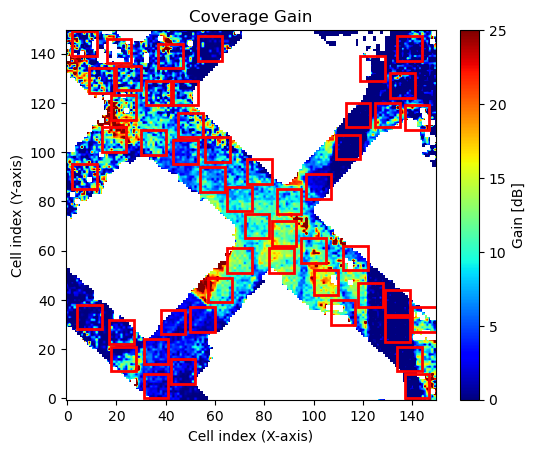

In [32]:
colormaps = ['jet']

# Loop over the colormap
for cmap in colormaps:
    fig5 = plt.figure()
    
    # Plot the base coverage map (in dB scale)
    plt.imshow(10 * np.log10(cm0._value[0] / cmb._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)
    plt.colorbar(label='Gain [dB]')
    
    # Add labels and title
    plt.xlabel('Cell index (X-axis)')
    plt.ylabel('Cell index (Y-axis)')
    plt.title("Coverage Gain")
    
    # Overlay the boundaries of the random areas
    for region in random_centers:
        (x_start, x_end, y_start, y_end), _ = region
        
        # Create a rectangle for the boundary, without filling it
        rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start,
                             linewidth=2, edgecolor='red', facecolor='none')
        
        # Add the rectangle to the plot
        plt.gca().add_patch(rect)
    
    # Save the figure as a high-resolution image
    fig5.savefig('Gain.png', dpi=1200, bbox_inches='tight')

# Show the plot with the boundaries
plt.show()

#Random material changing
Now we want to create a set of custom radio materials and iteratively assign them to objects in the scene. The materials are assigned in batches of 30 objects, ensuring all objects receive a material, with any remaining objects assigned the last material in the list.

In [18]:
materials_to_replace = []
for i in range(1, 4):
    material = RadioMaterial(f"my_material{i}", relative_permittivity=7, conductivity=0.0175,
                             scattering_coefficient=tf.Variable(0.5, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 0.01, 1)),
                             xpd_coefficient=0, scattering_pattern=BackscatteringPattern(alpha_r=10, alpha_i=8, lambda_=0.1))
    scene.add(material)
    materials_to_replace.append(material)
for i in range(4, 7):
    material = RadioMaterial(f"my_material{i}", relative_permittivity=7, conductivity=0.0175,
                             scattering_coefficient=tf.Variable(0.1, dtype=tf.float32, constraint=lambda x: tf.clip_by_value(x, 0.01, 1)),
                             xpd_coefficient=0, scattering_pattern=BackscatteringPattern(alpha_r=10, alpha_i=8, lambda_=0.1))
    scene.add(material)
    materials_to_replace.append(material)    
    
num_materials = len(materials_to_replace)
material_names = list(scene.objects.keys())  # Assuming each object has a unique material
# Step 2: Shuffle the list
random.shuffle(material_names)

# Step 4: Replace materials 10 by 10
batch_size = 30
for i, material in enumerate(materials_to_replace):
    start_idx = i * batch_size
    end_idx = start_idx + batch_size
    batch = material_names[start_idx:end_idx]
    
    for obj_name in batch:
        obj = scene.get(obj_name)  # Get the object
        if obj is not None:
            obj.radio_material = material  # Replace its material
    
    # Handle the case where the remaining materials are less than 10
    if end_idx >= len(material_names):
        break

# If there are remaining materials not yet replaced, apply the last material in the list
if end_idx < len(material_names):
    remaining_batch = material_names[end_idx:]
    for obj_name in remaining_batch:
        obj = scene.get(obj_name)
        if obj is not None:
            obj.radio_material = materials_to_replace[-1]  # Replace with the last material

In [19]:
for mat in list(scene.radio_materials.values()):
    if mat.is_used:
        print(f"Name: {mat.name}, Used by {mat.use_counter} scene objects.")

Name: my_material1, Used by 30 scene objects.
Name: my_material2, Used by 30 scene objects.
Name: my_material3, Used by 30 scene objects.
Name: my_material4, Used by 30 scene objects.
Name: my_material5, Used by 30 scene objects.
Name: my_material6, Used by 22 scene objects.


#Optimizer setup
Now we want to optimize the scattering coefficients of custom radio materials by minimizing the difference in path gains between coverage map subregions. In each training step, random subregions are selected, their path gains are computed, and a loss function is minimized using gradient descent with the Adam optimizer. The updated scattering coefficients are tracked and printed after each step.

In [22]:
optimizer = tf.keras.optimizers.Adam(0.01)
def to_db(x):
    return 10*tf.math.log(x)/tf.math.log(10.)
num_steps = 120

def train_step(cm_data):
    """A single training step"""
    with tf.GradientTape() as tape:
        keys = list(cm_data.keys())
        random.shuffle(keys)  # Shuffle the keys
        selected_keys = random.sample(keys, 1)  # Select 2 random keys

        # Get the corresponding subregion data and coordinates for the selected keys
        selected_cm1_maps = [cm_data[key]['subregion_linear'] for key in selected_keys]
        selected_centers = [cm_data[key]['physical_coordinates'] for key in selected_keys]  # Extract physical coordinates
        selected_grid_coords = [cm_data[key]['grid_coordinates'] for key in selected_keys]  # Extract grid coordinates

        # Print which centers [n, m] are used
        for key, grid_coord in zip(selected_keys, selected_grid_coords):
            print(f"Using center {key} with grid coordinates [n, m]: {grid_coord}")

        losses = []

        for cm1, center in zip(selected_cm1_maps, selected_centers):
            cm2 = scene.coverage_map(
                num_samples=int(10e6),  # Correct the multiplication to avoid float inputs for num_samples
                max_depth=6,
                los=True,
                reflection=True,
                diffraction=True,
                scattering=True,
                cm_cell_size=[1, 1],
                cm_orientation=[0, 0, 0],
                cm_center=center,
                cm_size=target_size2,
                check_scene=False
            )

            cm1_tensor = cm1

            # Convert cm2 (which is in linear scale) to a TensorFlow tensor
            cm2_tensor = cm2.as_tensor()

            # Calculate the path gain in linear scale for both tensors
            path_gain1 = to_db(tf.reduce_mean(cm2_tensor))
            path_gain2 = to_db(tf.reduce_mean(cm1_tensor))
            loss = tf.reduce_mean(tf.abs(path_gain1 - path_gain2) ** 2) / tf.reduce_mean((tf.abs(path_gain2) ** 2))
            losses.append(loss)

        total_loss = tf.reduce_mean(losses) if losses else 0  # Handle case where no valid cm1 maps are left

        # Compute gradients and apply through the optimizer
        grads = tape.gradient(total_loss, tape.watched_variables())
        optimizer.apply_gradients(zip(grads, tape.watched_variables()))

    return total_loss


trainable_materials_sca = [[] for _ in range(num_materials)]  
for step in range(num_steps):       
    total_loss = train_step(cm_data)
    
    # Append the current values for each material
    for i, material in enumerate(materials_to_replace):
        trainable_materials_sca[i].append(material.scattering_coefficient.numpy())

    # Optional: Print current state
    print(f"Training step {step}")
    for i, material in enumerate(materials_to_replace):
        print(f"Material {i+1} - Scattering Coefficient: {material.scattering_coefficient.numpy()}")
    print(total_loss.numpy())

Using center cm6 with grid coordinates [n, m]: [14, 138]
Training step 0
Material 1 - Scattering Coefficient: 0.5099718570709229
Material 2 - Scattering Coefficient: 0.509992778301239
Material 3 - Scattering Coefficient: 0.5095790028572083
Material 4 - Scattering Coefficient: 0.10997962951660156
Material 5 - Scattering Coefficient: 0.10995843261480331
Material 6 - Scattering Coefficient: 0.09406977891921997
0.00094420725
Using center cm25 with grid coordinates [n, m]: [106, 67]
Training step 1
Material 1 - Scattering Coefficient: 0.5190391540527344
Material 2 - Scattering Coefficient: 0.5196037888526917
Material 3 - Scattering Coefficient: 0.5193107724189758
Material 4 - Scattering Coefficient: 0.11982157826423645
Material 5 - Scattering Coefficient: 0.11339890211820602
Material 6 - Scattering Coefficient: 0.09004484862089157
0.0022373153
Using center cm17 with grid coordinates [n, m]: [14, 28]
Training step 2
Material 1 - Scattering Coefficient: 0.526275634765625
Material 2 - Scatteri

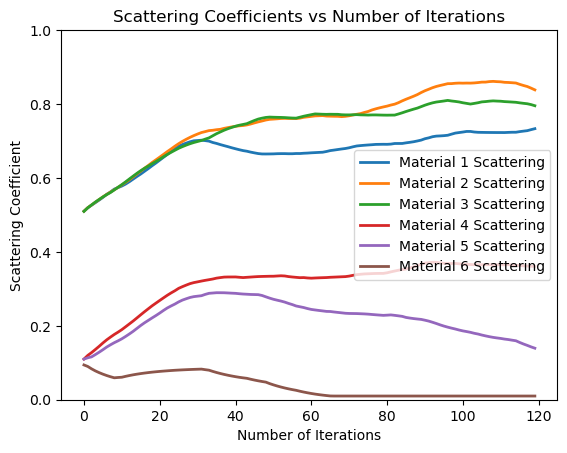

In [23]:
fig1 = plt.figure()
for i in range(num_materials):
    plt.plot(range(num_steps), trainable_materials_sca[i], label=f'Material {i+1} Scattering', linewidth=2)
plt.xlabel('Number of Iterations')
plt.ylabel('Scattering Coefficient')
plt.title('Scattering Coefficients vs Number of Iterations')
plt.ylim([0, 1])  # Assuming scattering coefficient is between 0 and 1
plt.legend()
plt.show()


This is how we calcualte the coverage map after material changing. 

In [24]:
cmT = scene.coverage_map(
                num_samples=1*(10e6), 
                max_depth=6,
                los=True,
                reflection=True,
                diffraction=True,
                scattering=True,
                cm_cell_size=[1,1],
                cm_orientation=[0,0,0],
                cm_center=cm_center,
                cm_size=cm_size,
                check_scene=False
            )


#Coverage Visualization 
Now we want to visualize and compare the coverage gain in dB for two coverage maps. One can see that the coverage gain is really close to the coverage gain before calibration. 

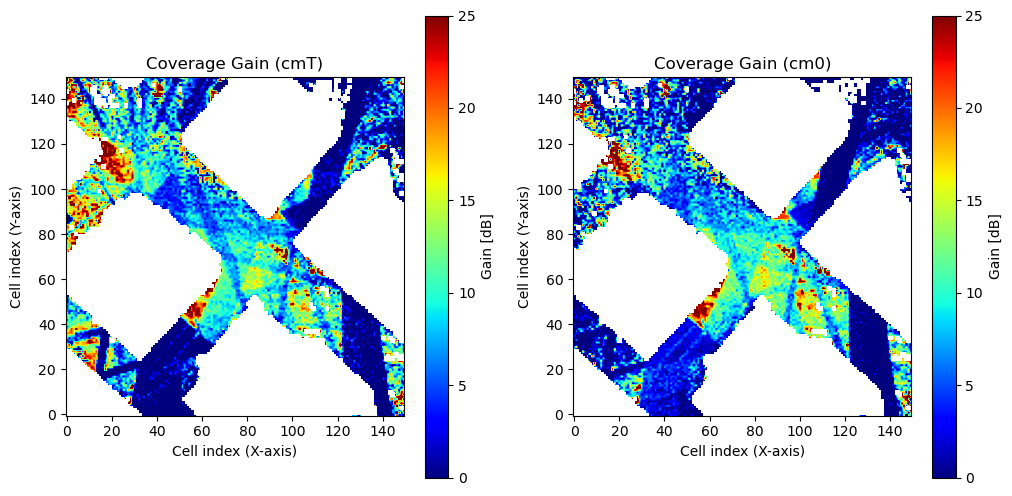

In [29]:
colormaps = ['jet']
for cmap in colormaps:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns for side-by-side plots

    # Plot cmT on the left
    im0 = axs[0].imshow(10 * np.log10(cmT._value[0] / cmb._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)
    axs[0].set_title("Coverage Gain (cmT)")
    axs[0].set_xlabel('Cell index (X-axis)')
    axs[0].set_ylabel('Cell index (Y-axis)')
    fig.colorbar(im0, ax=axs[0], label='Gain [dB]')

    # Plot cm0 on the right
    im1 = axs[1].imshow(10 * np.log10(cm0._value[0] / cmb._value[0]), cmap=cmap, origin='lower', vmin=0, vmax=25)
    axs[1].set_title("Coverage Gain (cm0)")
    axs[1].set_xlabel('Cell index (X-axis)')
    axs[1].set_ylabel('Cell index (Y-axis)')
    fig.colorbar(im1, ax=axs[1], label='Gain [dB]')

    # Save the figure as a high-resolution image
    fig.savefig('Gain_SideBySide.png', dpi=1200, bbox_inches='tight')

    # Show the plot
    plt.show()